<a href="https://colab.research.google.com/github/JWNLP/nmt_transformer/blob/main/epoch20_210628_new_transformer_mnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install en-core-web-sm
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install soynlp


In [22]:
!pip install spacy
!pip install spacy download en_core_web_sm
!pip install spacy download en

In [23]:
!pip install torch==1.9.0
!pip install Torchtext==0.6.0

## utils.py

In [24]:
import os
import re
import json
import pickle
from pathlib import Path

import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

from torchtext import data as ttd
from torchtext.data import Example, Dataset


def load_dataset(mode):
    """
    Load train, valid and test dataset as a pandas DataFrame
    Args:
        mode: (string) configuration mode used to which dataset to load
    Returns:
        (DataFrame) train, valid, test dataset converted to pandas DataFrame
    """
    print(f'Loading AI Hub Kor-Eng translation dataset and converting it to pandas DataFrame . . .')

    data_dir =  '/content/drive/MyDrive/transformer/data/'

    if mode == 'train':
        train_file = os.path.join(data_dir, 'train.csv')
        train_data = pd.read_csv(train_file, encoding='utf-8')

        valid_file = os.path.join(data_dir, 'valid.csv')
        valid_data = pd.read_csv(valid_file, encoding='utf-8')

        print(f'Number of training examples: {len(train_data)}')
        print(f'Number of validation examples: {len(valid_data)}')

        return train_data, valid_data

    else:
        test_file = os.path.join(data_dir, 'test.csv')
        test_data = pd.read_csv(test_file, encoding='utf-8')

        print(f'Number of testing examples: {len(test_data)}')

        return test_data


def clean_text(text):
    """
    remove special characters from the input sentence to normalize it
    Args:
        text: (string) text string which may contain special character
    Returns:
        normalized sentence
    """
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`…》]', '', text)
    return text


def convert_to_dataset(data, kor, eng):
    """
    Pre-process input DataFrame and convert pandas DataFrame to torchtext Dataset.
    Args:
        data: (DataFrame) pandas DataFrame to be converted into torchtext Dataset
        kor: torchtext Field containing Korean sentence
        eng: torchtext Field containing English sentence
    Returns:
        (Dataset) torchtext Dataset containing 'kor' and 'eng' Fields
    """
    # drop missing values not containing str value from DataFrame
    missing_rows = [idx for idx, row in data.iterrows() if type(row.korean) != str or type(row.english) != str]
    data = data.drop(missing_rows)

    # convert each row of DataFrame to torchtext 'Example' containing 'kor' and 'eng' Fields
    list_of_examples = [Example.fromlist(row.apply(lambda x: clean_text(x)).tolist(),
                                         fields=[('kor', kor), ('eng', eng)]) for _, row in data.iterrows()]

    # construct torchtext 'Dataset' using torchtext 'Example' list
    dataset = Dataset(examples=list_of_examples, fields=[('kor', kor), ('eng', eng)])
    return dataset


def make_iter(batch_size, mode, train_data=None, valid_data=None, test_data=None):
    """
    Convert pandas DataFrame to torchtext Dataset and make iterator which will be used to train and test the model
    Args:
        batch_size: (integer) batch size used to make iterators
        mode: (string) configuration mode used to which iterator to make
        train_data: (DataFrame) pandas DataFrame used to build train iterator
        valid_data: (DataFrame) pandas DataFrame used to build validation iterator
        test_data: (DataFrame) pandas DataFrame used to build test iterator
    Returns:
        (BucketIterator) train, valid, test iterator
    """
    # load text and label field made by build_pickles.py
    file_kor = open('/content/drive/MyDrive/transformer/pickles/kor.pickle', 'rb')
    kor = pickle.load(file_kor)

    file_eng = open('/content/drive/MyDrive/transformer/pickles/eng.pickle', 'rb')
    eng = pickle.load(file_eng)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # convert pandas DataFrame to torchtext dataset
    if mode == 'train':
        train_data = convert_to_dataset(train_data, kor, eng)
        valid_data = convert_to_dataset(valid_data, kor, eng)
        

        # make iterator using train and validation dataset
        # 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야 합니다.
          #따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋습니다.
          #이를 위해 BucketIterator를 사용합니다.
          #배치 크기(batch size): 128
        # iterator가 값을 차례대로 꺼낼 수 있는 객체라는 것의 의미
        # 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
        print(f'Make Iterators for training . . .')

        train_iter, valid_iter = ttd.BucketIterator.splits(
            (train_data, valid_data),
            # the BucketIterator needs to be told what function it should use to group the data.
            # In our case, we sort dataset using text of example
            sort_key=lambda sent: len(sent.kor),
            # all of the tensors will be sorted by their length by below option
            sort_within_batch=True,
            batch_size=batch_size,
            device=device)

        return train_iter, valid_iter
      
    else:
        test_data = convert_to_dataset(test_data, kor, eng)

        # defines dummy list will be passed to the BucketIterator
        dummy = list()

        # make iterator using test dataset
        print(f'Make Iterators for testing . . .')
        test_iter, _ = ttd.BucketIterator.splits(
            (test_data, dummy),
            sort_key=lambda sent: len(sent.kor),
            sort_within_batch=True,
            batch_size=batch_size,
            device=device)

        return test_iter


def epoch_time(start_time, end_time):
    """
    Calculate the time spent to train one epoch
    Args:
        start_time: (float) training start time
        end_time: (float) training end time
    Returns:
        (int) elapsed_mins and elapsed_sec spent for one epoch
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))

    return elapsed_mins, elapsed_secs


def display_attention(candidate, translation, attention):
    """
    displays the model's attention over the source sentence for each target token generated.
    Args:
        candidate: (list) tokenized source tokens
        translation: (list) predicted target translation tokens
        attention: a tensor containing attentions scores
    Returns:
    """
    # attention = [target length, source length]

    attention = attention.cpu().detach().numpy()
    # attention = [target length, source length]

    font_location = '/content/drive/MyDrive/transformer/pickles/NanumSquareR.ttf'
    fontprop = fm.FontProperties(fname=font_location)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    ax.matshow(attention, cmap='bone')
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + [t.lower() for t in candidate], rotation=45, fontproperties=fontprop)
    ax.set_yticklabels([''] + translation, fontproperties=fontprop)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


class Params:
    """
    Class that loads hyperparameters from a json file
    Example:
    ```
    params = Params(json_path)
    print(params.learning_rate)
    params.learning_rate = 0.5  # change the value of learning_rate in params
    ```
    """

    def __init__(self, json_path):
        self.update(json_path)
        self.load_vocab()

    def update(self, json_path):
        json_path ='/content/drive/MyDrive/transformer/data/params.json'
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def load_vocab(self):
        # load kor and eng vocabs to add vocab size configuration
        pickle_kor = open('/content/drive/MyDrive/transformer/pickles/kor.pickle', 'rb')
        kor = pickle.load(pickle_kor)

        pickle_eng = open('/content/drive/MyDrive/transformer/pickles/eng.pickle', 'rb')
        eng = pickle.load(pickle_eng)

        # add device information to the the params
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # add <sos> and <eos> tokens' indices used to predict the target sentence
        params = {'input_dim': len(kor.vocab), 'output_dim': len(eng.vocab),
                  'sos_idx': eng.vocab.stoi['<sos>'], 'eos_idx': eng.vocab.stoi['<eos>'],
                  'pad_idx': eng.vocab.stoi['<pad>'], 'device': device}

        self.__dict__.update(params)

    @property
    def dict(self):
        """Gives dict-like access to Params instance by `params.dict['learning_rate']`"""
        return self.__dict__

## build_pickles.py

In [7]:
import os
import pickle
import argparse # 코랩에선 config = parser.parse_args(args=[])
import easydict #코랩에선 argparse 대신 easydict

import pandas as pd
from pathlib import Path
#from utils import convert_to_dataset

from torchtext import data as ttd
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer


def build_tokenizer():
    """
    Train soynlp tokenizer which will be used to tokenize Korean input sentence
    """
    print(f'Now building soy-nlp tokenizer . . .')

    data_dir = '/content/drive/MyDrive/transformer/data/'
    train_file = os.path.join(data_dir, 'corpus.csv')

    df = pd.read_csv(train_file, encoding='utf-8')

    # if encounters non-text row, we should skip it
    kor_lines = [row.korean
                 for _, row in df.iterrows() if type(row.korean) == str]

    word_extractor = WordExtractor(min_frequency=5)
    word_extractor.train(kor_lines)

    word_scores = word_extractor.extract()
    cohesion_scores = {word: score.cohesion_forward
                       for word, score in word_scores.items()}
    
    with open('/content/drive/MyDrive/transformer/pickles/tokenizer.pickle', 'wb') as pickle_out:
        pickle.dump(cohesion_scores, pickle_out)


def build_vocab(config):
    """
    Build vocab used to convert input sentence into word indices using soynlp and spacy tokenizer
    Args:
        config: configuration containing various options
    """
    pickle_tokenizer = open('/content/drive/MyDrive/transformer/pickles/tokenizer.pickle', 'rb')
    cohesion_scores = pickle.load(pickle_tokenizer)
    tokenizer = LTokenizer(scores=cohesion_scores)

    # include lengths of the source sentences to use pack pad sequence
    kor = ttd.Field(tokenize=tokenizer.tokenize,
                    lower=True,
                    batch_first=True)

    eng = ttd.Field(tokenize='spacy',
                    init_token='<sos>',
                    eos_token='<eos>',
                    lower=True,
                    batch_first=True)

    data_dir = '/content/drive/MyDrive/transformer/data/'
    train_file = os.path.join(data_dir, 'train.csv')

    # train_data = pd.read_csv(train_file, encoding='utf-8') 이 코드에서 ParserError가 발생하면 engine이랑 delimiter 상세히 기입하기
    # ParserError: Error tokenizing data. C error: EOF inside string starting at row 27202 
    train_data = pd.read_csv(train_file, encoding='utf-8',engine='python', delimiter=',' )
    train_data = convert_to_dataset(train_data, kor, eng)

    print(f'Build vocabulary using torchtext . . .')

    kor.build_vocab(train_data, max_size=config.kor_vocab)
    eng.build_vocab(train_data, max_size=config.eng_vocab)

    print(f'Unique tokens in Korean vocabulary: {len(kor.vocab)}')
    print(f'Unique tokens in English vocabulary: {len(eng.vocab)}')

    print(f'Most commonly used Korean words are as follows:')
    print(kor.vocab.freqs.most_common(20))

    print(f'Most commonly used English words are as follows:')
    print(eng.vocab.freqs.most_common(20))

    with open('/content/drive/MyDrive/transformer/pickles/kor.pickle', 'wb') as kor_file:
        pickle.dump(kor, kor_file)

    with open('/content/drive/MyDrive/transformer/pickles/eng.pickle', 'wb') as eng_file:
        pickle.dump(eng, eng_file)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Pickle Builder')

    parser.add_argument('--kor_vocab', type=int, default=55000)
    parser.add_argument('--eng_vocab', type=int, default=30000)

    config = parser.parse_args(args=[])
    #Jupyter notebook에서 argparse 이용할 때, 굳이 easydict으로 안바꾸고
    # 마지막 config = parser.parse_args() 괄호안에 args=[] 추가

    #parser = easydict.EasyDict({
    #    "kor_vocab":55000,
    #    "eng_vocab":30000
    #})

    #config = parser.parse_args(config=[])

    

    build_tokenizer()
    build_vocab(config)

Now building soy-nlp tokenizer . . .
training was done. used memory 0.550 Gb
all cohesion probabilities was computed. # words = 46586
all branching entropies was computed # words = 112737
all accessor variety was computed # words = 112737
Build vocabulary using torchtext . . .
Unique tokens in Korean vocabulary: 31035
Unique tokens in English vocabulary: 11662
Most commonly used Korean words are as follows:
[('이', 3230), ('는', 2397), ('을', 2009), ('에', 1979), ('수', 1892), ('은', 1845), ('가', 1808), ('를', 1629), ('당신', 1617), ('해요', 1492), ('나는', 1461), ('요', 1443), ('의', 1367), ('우리', 1306), ('있어', 1277), ('할', 1238), ('것', 1225), ('서', 1204), ('한', 1082), ('있는', 1047)]
Most commonly used English words are as follows:
[('i', 13951), ('the', 13051), ('to', 9422), ('you', 8086), ('a', 6893), ('is', 5507), ('it', 5361), ('in', 3772), ('of', 3479), ('and', 3476), ('for', 3006), ('that', 2828), ('do', 2798), ('have', 2687), ("'s", 2665), ('we', 2602), ('my', 2502), ('this', 2434), ("n't", 23

##model/ops.py

In [8]:
import pickle
import numpy as np
import torch
import torch.nn as nn

pickle_eng = open('/content/drive/MyDrive/transformer/pickles/eng.pickle', 'rb')
eng = pickle.load(pickle_eng)
pad_idx = eng.vocab.stoi['<pad>']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def create_subsequent_mask(target):
    """
    if target length is 5 and diagonal is 1, this function returns
        [[0, 1, 1, 1, 1],
         [0, 0, 1, 1, 1],
         [0, 0, 0, 1, 1],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0]]
    :param target: [batch size, target length]
    :return:
    """
    batch_size, target_length = target.size()

    # torch.triu returns the upper triangular part of a matrix based on user defined diagonal
    subsequent_mask = torch.triu(torch.ones(target_length, target_length), diagonal=1).bool().to(device)
    # subsequent_mask = [target length, target length]

    # repeat subsequent_mask 'batch size' times to cover all data instances in the batch
    subsequent_mask = subsequent_mask.unsqueeze(0).repeat(batch_size, 1, 1)
    # subsequent_mask = [batch size, target length, target length]

    return subsequent_mask


def create_source_mask(source):
    """
    create masking tensor for encoder's self attention
    if sentence is [2, 193, 9, 27, 10003, 1, 1, 1, 3] and 2 denotes <sos>, 3 denotes <eos> and 1 denotes <pad>
    masking tensor will be [False, False, False, False, False, True, True, True, False]
    :param source: [batch size, source length]
    :return: source mask
    """
    source_length = source.shape[1]

# 내가 변경한 코드 source_pad_idx 
    # create boolean tensors which will be used to mask padding tokens of both source and target sentence
    source_pad_idx = (source == pad_idx)
    # source_mask = [batch size, source length]

    
    ## create boolean tensors which will be used to mask padding tokens of both source and target sentence
    #source_mask = (source == pad_idx)
    ## source_mask = [batch size, source length]

    # repeat sentence masking tensors 'sentence length' times
    source_mask = source_pad_idx.unsqueeze(1).repeat(1, source_length, 1)
    # source_mask = [batch size, source length, source length]

    return source_mask


def create_target_mask(source, target):
    """
    create masking tensor for decoder's self attention and decoder's attention on the output of encoder
    if sentence is [2, 193, 9, 27, 10003, 1, 1, 1, 3] and 2 denotes <sos>, 3 denotes <eos> and 1 denotes <pad>
    masking tensor will be [False, False, False, False, False, True, True, True, False]
    :param source: [batch size, source length]
    :param target: [batch size, target length]
    :return:
    """
    target_length = target.shape[1]

    subsequent_mask = create_subsequent_mask(target)
    # subsequent_mask = [batch size, target length, target length]

# 내가 변경한 코드 source_pad_idx, target_pad_idx
    source_pad_idx = (source == pad_idx)
    target_pad_idx = (target == pad_idx)
    # target_mask    = [batch size, target length]

    # repeat sentence masking tensors 'sentence length' times
    dec_enc_mask = source_pad_idx.unsqueeze(1).repeat(1, target_length, 1)
    target_mask = target_pad_idx.unsqueeze(1).repeat(1, target_length, 1)


    #source_mask = (source == pad_idx)
    #target_mask = (target == pad_idx)
    ## target_mask    = [batch size, target length]


    # repeat sentence masking tensors 'sentence length' times
    #dec_enc_mask = source_mask.unsqueeze(1).repeat(1, target_length, 1)
    #target_mask = target_pad_idx.unsqueeze(1).repeat(1, target_length, 1)

    # combine <pad> token masking tensor and subsequent masking tensor for decoder's self attention
    target_mask = target_mask | subsequent_mask
    # target_mask = [batch size, target length, target length]
    return target_mask, dec_enc_mask


def create_position_vector(sentence):
    """
    create position vector which contains positional information
    0th position is used for pad index
    :param sentence: [batch size, sentence length]
    :return: [batch size, sentence length]
    """
    # sentence = [batch size, sentence length]
    batch_size, _ = sentence.size()
    pos_vec = np.array([(pos+1) if word != pad_idx else 0
                        for row in range(batch_size) for pos, word in enumerate(sentence[row])])
    pos_vec = pos_vec.reshape(batch_size, -1)
    pos_vec = torch.LongTensor(pos_vec).to(device)
    return pos_vec


def create_positional_encoding(max_len, hidden_dim):
    # PE(pos, 2i)     = sin(pos/10000 ** (2*i / hidden_dim))
    # PE(pos, 2i + 1) = cos(pos/10000 ** (2*i / hidden_dim))
    sinusoid_table = np.array([pos / np.power(10000, 2 * i / hidden_dim)
                               for pos in range(max_len) for i in range(hidden_dim)])
    # sinusoid_table = [max len * hidden dim]

    sinusoid_table = sinusoid_table.reshape(max_len, -1)
    # sinusoid_table = [max len, hidden dim]

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # calculate pe for even dimension
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # calculate pe for odd dimension

    # convert numpy based sinusoid table to torch.tensor and repeat it 'batch size' times
    sinusoid_table = torch.FloatTensor(sinusoid_table).to(device)
    sinusoid_table[0] = 0.

    return sinusoid_table


def init_weight(layer):
    nn.init.xavier_uniform_(layer.weight)
    if layer.bias is not None:
        nn.init.constant_(layer.bias, 0)

##model/attention.py

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#from model.ops import init_weight

# Multi Head Attention 아키텍처
# 어텐션(attention)은 세 가지 요소를 입력으로 받습니다.
# 쿼리(queries), 키(keys), 값(values)
# 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
  #하이퍼 파라미터(hyperparameter)
    # hidden_dim: 하나의 단어에 대한 임베딩 차원
    # n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    # dropout_ratio: 드롭아웃(dropout) 비율


class MultiHeadAttention(nn.Module):
    def __init__(self, params):
        super(MultiHeadAttention, self).__init__()
        assert params.hidden_dim % params.n_head == 0
        self.attentions = nn.ModuleList([SelfAttention(params)
                                         for _ in range(params.n_head)])
        self.o_w = nn.Linear(params.hidden_dim, params.hidden_dim, bias=False)
        init_weight(self.o_w)
        self.dropout = nn.Dropout(params.dropout)

    def forward(self, query, key, value, mask=None):
        # query, key, value = [batch size, sentence length, hidden dim]

        self_attentions = [attention(query, key, value, mask) for attention in self.attentions]
        # self_attentions = [batch size, sentence length, attention dim] * num head
        weighted_vs = [weighted_v[0] for weighted_v in self_attentions] # weighted value
        attentions = [weighted_v[1] for weighted_v in self_attentions]

        weighted_v = torch.cat(weighted_vs, dim=-1)
        # weighted_v = [batch size, sentence length, hidden dim]

        output = self.dropout(self.o_w(weighted_v))
        # output = [batch size, sentence length, hidden dim]

        return output, attentions


class SelfAttention(nn.Module):
    def __init__(self, params):
        super(SelfAttention, self).__init__()
        self.hidden_dim = params.hidden_dim
        self.attention_dim = params.hidden_dim // params.n_head

        self.q_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=False)
        self.k_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=False)
        self.v_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=False)
        init_weight(self.q_w)
        init_weight(self.k_w)
        init_weight(self.v_w)

        self.dropout = nn.Dropout(params.dropout)
        self.scale_factor = torch.sqrt(torch.FloatTensor([self.attention_dim])).to(params.device)

    def forward(self, query, key, value, mask=None):
        # query, key, value = [batch size, sentence length, hidden dim]

        # create Q, K, V matrices using identical input sentence to calculate self-attention score
        q = self.q_w(query)
        k = self.k_w(key)
        v = self.v_w(value)
        # q, k, v = [batch size, sentence length, attention dim]

        self_attention = torch.bmm(q, k.permute(0, 2, 1))
        self_attention = self_attention / self.scale_factor
        # self_attention = [batch size, sentence length, sentence length]

        if mask is not None:
            self_attention = self_attention.masked_fill(mask, -np.inf)

        # normalize self attention score by applying soft max function on each row
        attention_score = F.softmax(self_attention, dim=-1)
        norm_attention_score = self.dropout(attention_score)
        # attention_score = [batch size, sentence length, sentence length]

        # compute "weighted" value matrix using self attention score and V matrix
        weighted_v = torch.bmm(norm_attention_score, v)
        # weighted_v = [batch size, sentence length, attention dim]

        return self.dropout(weighted_v), attention_score

##model/positionwise.py

In [10]:
import torch.nn as nn
import torch.nn.functional as F

#from model.ops import init_weight


class PositionWiseFeedForward(nn.Module):
    def __init__(self, params):
        super(PositionWiseFeedForward, self).__init__()
        # nn.Conv1d takes input whose size is (N, C): N is a batch size, C denotes a number of channels
        self.conv1 = nn.Conv1d(params.hidden_dim, params.feed_forward_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(params.feed_forward_dim, params.hidden_dim, kernel_size=1)
        init_weight(self.conv1)
        init_weight(self.conv2)
        self.dropout = nn.Dropout(params.dropout)

    def forward(self, x):
        # x = [batch size, sentence length, hidden dim]

        # permute x's indices to apply nn.Conv1d on input 'x'
        x = x.permute(0, 2, 1)                        # x = [batch size, hidden dim, sentence length]
        output = self.dropout(F.relu(self.conv1(x)))  # output = [batch size, feed forward dim, sentence length)
        output = self.conv2(output)                   # output = [batch size, hidden dim, sentence length)

        # permute again to restore output's original indices
        output = output.permute(0, 2, 1)              # output = [batch size, sentence length, hidden dim]
        return self.dropout(output)

##model/encoder.py

In [11]:
import torch.nn as nn

#from model.attention import MultiHeadAttention
#from model.positionwise import PositionWiseFeedForward
#from model.ops import create_positional_encoding, create_source_mask, create_position_vector


class EncoderLayer(nn.Module):
    def __init__(self, params):
        super(EncoderLayer, self).__init__()
        self.layer_norm = nn.LayerNorm(params.hidden_dim, eps=1e-6)
        self.self_attention = MultiHeadAttention(params)
        self.position_wise_ffn = PositionWiseFeedForward(params)

    def forward(self, source, source_mask):
        # source          = [batch size, source length, hidden dim]
        # source_mask     = [batch size, source length, source length]

        # Original Implementation: LayerNorm(x + SubLayer(x)) -> Updated Implementation: x + SubLayer(LayerNorm(x))
        normalized_source = self.layer_norm(source)
        output = source + self.self_attention(normalized_source, normalized_source, normalized_source, source_mask)[0]

        normalized_output = self.layer_norm(output)
        output = output + self.position_wise_ffn(normalized_output)
        # output = [batch size, source length, hidden dim]

        return output


class Encoder(nn.Module):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.token_embedding = nn.Embedding(params.input_dim, params.hidden_dim, padding_idx=params.pad_idx)
        nn.init.normal_(self.token_embedding.weight, mean=0, std=params.hidden_dim**-0.5)
        self.embedding_scale = params.hidden_dim ** 0.5
        self.pos_embedding = nn.Embedding.from_pretrained(
            create_positional_encoding(params.max_len+1, params.hidden_dim), freeze=True)

        self.encoder_layers = nn.ModuleList([EncoderLayer(params) for _ in range(params.n_layer)])
        self.dropout = nn.Dropout(params.dropout)
        self.layer_norm = nn.LayerNorm(params.hidden_dim, eps=1e-6)

    def forward(self, source):
        # source = [batch size, source length]
        source_mask = create_source_mask(source)      # [batch size, source length, source length]
        source_pos = create_position_vector(source)   # [batch size, source length]

        source = self.token_embedding(source) * self.embedding_scale

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        source = self.dropout(source + self.pos_embedding(source_pos))
        # source = [batch size, source length, hidden dim]


       # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for encoder_layer in self.encoder_layers:
            source = encoder_layer(source, source_mask)
        # source = [batch size, source length, hidden dim]

        return self.layer_norm(source)

##model/decoder.py

In [12]:
import torch
import torch.nn as nn

#from model.attention import MultiHeadAttention
#from model.positionwise import PositionWiseFeedForward
#from model.ops import create_positional_encoding, create_target_mask, create_position_vector


class DecoderLayer(nn.Module):
    def __init__(self, params):
        super(DecoderLayer, self).__init__()
        self.layer_norm = nn.LayerNorm(params.hidden_dim, eps=1e-6)
        self.self_attention = MultiHeadAttention(params)
        self.encoder_attention = MultiHeadAttention(params)
        self.position_wise_ffn = PositionWiseFeedForward(params)

    def forward(self, target, encoder_output, target_mask, dec_enc_mask):
        # target          = [batch size, target length, hidden dim]
        # encoder_output  = [batch size, source length, hidden dim]
        # target_mask     = [batch size, target length, target length]
        # dec_enc_mask    = [batch size, target length, source length]

        # Original Implementation: LayerNorm(x + SubLayer(x)) -> Updated Implementation: x + SubLayer(LayerNorm(x))
        norm_target = self.layer_norm(target)
        output = target + self.self_attention(norm_target, norm_target, norm_target, target_mask)[0]

        # In Decoder stack, query is the output from below layer and key & value are the output from the Encoder
        norm_output = self.layer_norm(output)
        sub_layer, attn_map = self.encoder_attention(norm_output, encoder_output, encoder_output, dec_enc_mask)
        output = output + sub_layer

        norm_output = self.layer_norm(output)
        output = output + self.position_wise_ffn(norm_output)
        # output = [batch size, target length, hidden dim]

        return output, attn_map


class Decoder(nn.Module):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.token_embedding = nn.Embedding(params.output_dim, params.hidden_dim, padding_idx=params.pad_idx)
        nn.init.normal_(self.token_embedding.weight, mean=0, std=params.hidden_dim**-0.5)
        self.embedding_scale = params.hidden_dim ** 0.5
        self.pos_embedding = nn.Embedding.from_pretrained(
            create_positional_encoding(params.max_len+1, params.hidden_dim), freeze=True)

        self.decoder_layers = nn.ModuleList([DecoderLayer(params) for _ in range(params.n_layer)])
        self.dropout = nn.Dropout(params.dropout)
        self.layer_norm = nn.LayerNorm(params.hidden_dim, eps=1e-6)

    def forward(self, target, source, encoder_output):
        # target              = [batch size, target length]
        # source              = [batch size, source length]
        # encoder_output      = [batch size, source length, hidden dim]
        target_mask, dec_enc_mask = create_target_mask(source, target)
        # target_mask / dec_enc_mask  = [batch size, target length, target/source length]
        target_pos = create_position_vector(target)  # [batch size, target length]

        target = self.token_embedding(target) * self.embedding_scale
        target = self.dropout(target + self.pos_embedding(target_pos))
        # target = [batch size, target length, hidden dim]

        for decoder_layer in self.decoder_layers:
            target, attention_map = decoder_layer(target, encoder_output, target_mask, dec_enc_mask)
        # target = [batch size, target length, hidden dim]

        target = self.layer_norm(target)
        output = torch.matmul(target, self.token_embedding.weight.transpose(0, 1))
        # output = [batch size, target length, output dim]
        return output, attention_map

##model/transformer.py

In [13]:
import torch.nn as nn

#from model.encoder import Encoder
#from model.decoder import Decoder


class Transformer(nn.Module):
    def __init__(self, params):
        super(Transformer, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)

    def forward(self, source, target):
        # source = [batch size, source length]
        # target = [batch size, target length]
        encoder_output = self.encoder(source)                            # [batch size, source length, hidden dim]
        output, attn_map = self.decoder(target, source, encoder_output)  # [batch size, target length, output dim]
        return output, attn_map

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

##noam optimizer
attetion all you need
http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer

noam optimizer
https://nn.labml.ai/optimizers/noam.html

Q: Why does transformer use noam as the learning rate decay scheme?

A: All the multiplications are performed because T2T uses normalized values: we try to make the learning rate of 0.1 work with various optimizers (normally Adam would use 0.002 or so) and we try to make weight-decay per-parameter (people usually tune it per-model, but then whenever you change hidden_size you need to change that too, and a number of other things and so on). I can see that the normalized choices are sometimes confusing when compared to the literature, but it's very hard to make different models and hparam_sets work ok without some form of normalization.

# Lr Scheduler
Lr Scheduler는 미리 학습 일정을 정해두고, 그 일정에 따라 학습률을 조정하는 방법입니다. 일반적으로는 warmup이라는 파라미터를 정하고 current_step이 warmup보다 낮을 경우는 learning rate를 linear하게 증가 시키고, warmup 후에는 각 Lr Scheduler에서 정한 방법대로 learning rate를 update합니다.


# Noam Lr Scheduler
linear한 warmup 후 inverse square root를 취하여 업데이트 하는 방식입니다. 'Attention is all you need" 논문에서 transformer 업데이트에 사용한 Lr Scheduler입니다.


lr = scale_factor * ( (model_dim ** (-0.5)) * adj_step )

adj_step = min(step_num ** (-0.5), step_num * warmup_steps ** (-1.5))

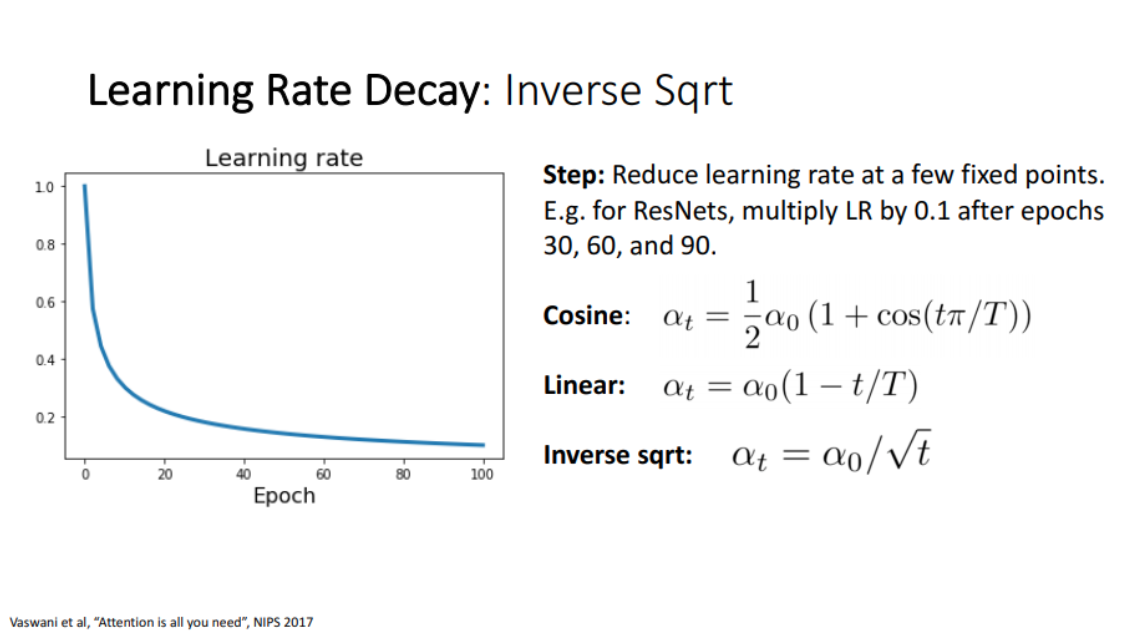

그리고 다른 연속적인 Learning Rate Decay로 Inverse Sqrt(Inverse Square Root) Decay가 있습니다.

Inverse Sqrt Decay는 수식을 보면 t 역 제곱근의 a 
0
​
 로 나타내어 집니다.

그리고 Cosine decay와 비슷한 Learning rate 그래프를 나타내지만, Cosine decay보다 Inverse Sqrt Decay가 더 빠르게 감소 되는것을 알 수 있습니다.

위의 이유로 Learning Rate Decay를 고려할 때 Inverse Sqrt보다 Cosine decay가 parameter space를 더 넓게 탐색한다고 생각을하고 Cosine decay를 더 많이 사용한다고 합니다.

##model/optim.py

In [14]:
#attetion all you need
#noam optimizer
#https://nn.labml.ai/optimizers/noam.html


import numpy as np


class ScheduledAdam():
    def __init__(self, optimizer, hidden_dim, warm_steps):
        self.init_lr = np.power(hidden_dim, -0.5)
        self.optimizer = optimizer
        self.current_steps = 0
        self.warm_steps = warm_steps

    def step(self):
        # Update learning rate using current step information
        self.current_steps += 1
        lr = self.init_lr * self.get_scale()  # lr = scale_factor * ( (model_dim ** (-0.5)) * adj_step )

        for p in self.optimizer.param_groups:
            p['lr'] = lr

        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_scale(self):  # adj_step = min(step_num ** (-0.5), step_num * warmup_steps ** (-1.5))
        return np.min([
            np.power(self.current_steps, -0.5),
            self.current_steps * np.power(self.warm_steps, -1.5)
        ])



##bleu.py

In [15]:
"""
@author : Hyunwoong
@when : 2019-12-22
@homepage : https://github.com/gusdnd852
"""
import math
from collections import Counter

import numpy as np


def bleu_stats(hypothesis, reference):
    """Compute statistics for BLEU."""
    stats = []
    stats.append(len(hypothesis))
    stats.append(len(reference))
    for n in range(1, 5):
        s_ngrams = Counter(
            [tuple(hypothesis[i:i + n]) for i in range(len(hypothesis) + 1 - n)]
        )
        r_ngrams = Counter(
            [tuple(reference[i:i + n]) for i in range(len(reference) + 1 - n)]
        )

        stats.append(max([sum((s_ngrams & r_ngrams).values()), 0]))
        stats.append(max([len(hypothesis) + 1 - n, 0]))
    return stats


def bleu(stats):
    """Compute BLEU given n-gram statistics."""
    if len(list(filter(lambda x: x == 0, stats))) > 0:
        return 0
    (c, r) = stats[:2]
    log_bleu_prec = sum(
        [math.log(float(x) / y) for x, y in zip(stats[2::2], stats[3::2])]
    ) / 4.
    return math.exp(min([0, 1 - float(r) / c]) + log_bleu_prec)


def get_bleu(hypotheses, reference):
    """Get validation BLEU score for dev set."""
    stats = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for hyp, ref in zip(hypotheses, reference):
        stats += np.array(bleu_stats(hyp, ref))
    return 100 * bleu(stats)


def idx_to_word(x, vocab):
    words = []
    for i in x:
        word = vocab.itos[i]
        if '<' not in word:
            words.append(word)
    words = " ".join(words)
    return words

##trainer.py

In [16]:
import time
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim

#from utils import epoch_time
#from model.optim import ScheduledAdam
#from model.transformer import Transformer

random.seed(32)
torch.manual_seed(32)
torch.backends.cudnn.deterministic = True


class Trainer:
    def __init__(self, params, mode, train_iter=None, valid_iter=None, test_iter=None):
        self.params = params

        # Train mode
        if mode == 'train':
            self.train_iter = train_iter
            self.valid_iter = valid_iter

        # Test mode
        else:
            self.test_iter = test_iter

        self.model = Transformer(self.params)
        self.model.to(self.params.device)

        # Scheduling Optimzer
        self.optimizer = ScheduledAdam(
            optim.Adam(self.model.parameters(), betas=(0.9, 0.98), eps=1e-9),
            hidden_dim=params.hidden_dim,
            warm_steps=params.warm_steps
                      
            
            )
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
        self.criterion = nn.CrossEntropyLoss(ignore_index=self.params.pad_idx)
        self.criterion.to(self.params.device)

    
    #학습(training) 및 검증(validation) 진행
    def train(self):
        print(self.model)
        print(f'The model has {self.model.count_params():,} trainable parameters')
        best_valid_loss = float('inf')

        for epoch in range(self.params.num_epoch):
            self.model.train()
            epoch_loss = 0
            start_time = time.time() # 시작 시간 기록

            # 전체 학습 데이터를 확인하며
            for batch in self.train_iter:
                # For each batch, first zero the gradients
                self.optimizer.zero_grad()
                source = batch.kor
                target = batch.eng


                # 출력 단어의 마지막 인덱스(<eos>)는 제외
                # target sentence consists of <sos> and following tokens (except the <eos> token)
                output = self.model(source, target[:, :-1])[0]

                # 입력을 할 때는 <sos>부터 시작하도록 처리
                # ground truth sentence consists of tokens and <eos> token (except the <sos> token)
                output = output.contiguous().view(-1, output.shape[-1])

                # 출력 단어의 인덱스 0(<sos>)은 제외
                target = target[:, 1:].contiguous().view(-1)

                # output = [(batch size * target length - 1), output dim]
                # target = [(batch size * target length - 1)]
                
                # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
                loss = self.criterion(output, target)
                loss.backward()  # 기울기(gradient) 계산


                # 기울기(gradient) clipping 진행
                # clip the gradients to prevent the model from exploding gradient
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.params.clip)

                # 파라미터 업데이트
                self.optimizer.step()

                # 전체 손실 값 계산
                # 'item' method is used to extract a scalar from a tensor which only contains a single value.
                epoch_loss += loss.item()

            train_loss = epoch_loss / len(self.train_iter)
            valid_loss = self.evaluate() 

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                # 모델 저장
                torch.save(self.model.state_dict(), self.params.save_model) # "save_model": "model.pt",
                #torch.save(model, PATH + 'model.pt'
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
            print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):.3f}')


    def evaluate(self):
        self.model.eval() #평가 모드
        epoch_loss = 0

        # 전체 평가 데이터를 확인하며
        with torch.no_grad():
            for batch in self.valid_iter:
                source = batch.kor
                target = batch.eng

                # 출력 단어의 마지막 인덱스(<eos>)는 제외
                output = self.model(source, target[:, :-1])[0]

                # 입력을 할 때는 <sos>부터 시작하도록 처리
                output = output.contiguous().view(-1, output.shape[-1])

                # output = [(batch size * target length - 1), output dim]
                # target = [(batch size * target length - 1)]
                
                # 출력 단어의 인덱스 0(<sos>)은 제외
                target = target[:, 1:].contiguous().view(-1)

                # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
                loss = self.criterion(output, target)

                # 전체 손실 값 계산
                epoch_loss += loss.item()

        return epoch_loss / len(self.valid_iter)

    def test(self):
        self.model.load_state_dict(torch.load(self.params.save_model))
        self.model.eval()
        epoch_loss = 0

        with torch.no_grad():
            for batch in self.test_iter:
                source = batch.kor
                target = batch.eng

                output = self.model(source, target[:, :-1])[0]

                output = output.contiguous().view(-1, output.shape[-1])
                target = target[:, 1:].contiguous().view(-1)

                loss = self.criterion(output, target)

                epoch_loss += loss.item()

        test_loss = epoch_loss / len(self.test_iter)
        print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

##train_model.py

In [17]:
import csv
import argparse
#from trainer import Trainer
#from utils import load_dataset, make_iter, Params


def train_model(config):
    params = Params('/content/drive/MyDrive/transformer/data/params.json')

    if config.mode == 'train':
        train_data, valid_data = load_dataset(config.mode)
        train_iter, valid_iter = make_iter(params.batch_size, config.mode,
                                           train_data=train_data, valid_data=valid_data)

        trainer = Trainer(params, config.mode, train_iter=train_iter, valid_iter=valid_iter)
        trainer.train()

    else:
        test_data = load_dataset(config.mode)
        test_iter = make_iter(params.batch_size, config.mode, test_data=test_data)

        trainer = Trainer(params, config.mode, test_iter=test_iter)
        trainer.test()


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Transformer Neural Machine Translation')
    parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
    args = parser.parse_args(args=[])
    train_model(args)

Loading AI Hub Kor-Eng translation dataset and converting it to pandas DataFrame . . .
Number of training examples: 27201
Number of validation examples: 11500
Make Iterators for training . . .
Transformer(
  (encoder): Encoder(
    (token_embedding): Embedding(31035, 512, padding_idx=1)
    (pos_embedding): Embedding(65, 512)
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiHeadAttention(
          (attentions): ModuleList(
            (0): SelfAttention(
              (q_w): Linear(in_features=512, out_features=64, bias=False)
              (k_w): Linear(in_features=512, out_features=64, bias=False)
              (v_w): Linear(in_features=512, out_features=64, bias=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): SelfAttention(
              (q_w): Linear(in_features=512, out_features=64, bias=False)
              (k_w): Linea

In [18]:
import csv
import argparse
#from trainer import Trainer
#from utils import load_dataset, make_iter, Params


def test_model(config):
    params = Params('/content/drive/MyDrive/transformer/data/test_params.json')
    #model.load_state_dict(torch.load('/content/model.pt'))
    if config.mode == 'test':
        test_data = load_dataset(config.mode)
        test_iter = make_iter(params.batch_size, config.mode, test_data=test_data)

        trainer = Trainer(params, config.mode, test_iter=test_iter)
        trainer.test()

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Transformer Neural Machine Translation')
    parser.add_argument('--mode', type=str, default='test', choices=['train', 'test'])
    args = parser.parse_args(args=[])
    test_model(args)

Loading AI Hub Kor-Eng translation dataset and converting it to pandas DataFrame . . .
Number of testing examples: 11500
Make Iterators for testing . . .
Test Loss: 3.943 | Test PPL: 51.565


kor> 내일 나는 학교에 가요.
eng> I will go to school tomorrow


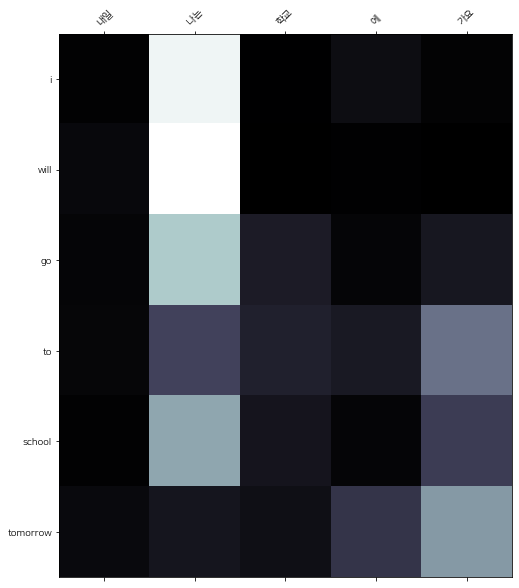

In [30]:
import pickle
import argparse

import torch
from soynlp.tokenizer import LTokenizer
from torchtext.data import Example, Dataset

#from utils import Params, clean_text, display_attention
#from model.transformer import Transformer


def predict(config):
    input = clean_text(config.input)
    params = Params('config/params.json')

    # load tokenizer and torchtext Fields
    pickle_tokenizer = open('/content/drive/MyDrive/transformer/pickles/tokenizer.pickle', 'rb')
    cohesion_scores = pickle.load(pickle_tokenizer)
    tokenizer = LTokenizer(scores=cohesion_scores)

    pickle_kor = open('/content/drive/MyDrive/transformer/pickles/kor.pickle', 'rb')
    kor = pickle.load(pickle_kor)
    pickle_eng = open('/content/drive/MyDrive/transformer/pickles/eng.pickle', 'rb')
    eng = pickle.load(pickle_eng)
    eos_idx = eng.vocab.stoi['<eos>']

    # select model and load trained model
    model = Transformer(params)
    model.load_state_dict(torch.load(params.save_model))
    model.to(params.device)
    model.eval()

    # convert input into tensor and forward it through selected model
    tokenized = tokenizer.tokenize(input)
    indexed = [kor.vocab.stoi[token] for token in tokenized]

    source = torch.LongTensor(indexed).unsqueeze(0).to(params.device)  # [1, source_len]: unsqueeze to add batch size
    target = torch.zeros(1, params.max_len).type_as(source.data)       # [1, max_len]

    encoder_output = model.encoder(source)
    next_symbol = eng.vocab.stoi['<sos>']

    for i in range(0, params.max_len):
        target[0][i] = next_symbol
        decoder_output, _ = model.decoder(target, source, encoder_output)  # [1, target length, output dim]
        prob = decoder_output.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()

    eos_idx = int(torch.where(target[0] == eos_idx)[0][0])
    target = target[0][:eos_idx].unsqueeze(0)

    # translation_tensor = [target length] filed with word indices
    target, attention_map = model(source, target)
    target = target.squeeze(0).max(dim=-1)[1]
    
    translated_token = [eng.vocab.itos[token] for token in target]
    translation = translated_token[:translated_token.index('<eos>')]
    translation = ' '.join(translation)

   

    print(f'kor> {config.input}')
    print(f'eng> {translation.capitalize()}')
    display_attention(tokenized, translated_token, attention_map[4].squeeze(0)[:-1])


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Kor-Eng Translation prediction')
    parser.add_argument('--input', type=str, default='내일 나는 학교에 가요.')

    option = parser.parse_args(args=[])

    predict(option)

In [31]:
def cal_bleu_score(test_data, test_model, kor_vocab, eng_vocab):
    targets = []
    predictions = []
 
    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['eng']
        predicted_words = predict(i, test_model, kor_vocab, eng_vocab, test_data)
        predictions.append(predicted_words[1:-1])
        targets.append([target])
 
    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 4)}')